# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

# Exoplanet data packages
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

# Dynamic nested sampling
import dynesty
from dynesty import NestedSampler, DynamicNestedSampler
from dynesty import plotting as dyplot

# Library of custom functions
import TESSPhaseCurve_lib as TPC

# Matplotlib settings
from matplotlib import font_manager
font_dir = ['/home/paiasnodkar.1/fonts'] # This will not work for you since it is a local directory on my system
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

fontweight = 300
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22

# Read in data

Period:  0.94145299 d +/-  8.7e-07 d
t_0:  2454221.48163 d +/-  0.00038 d
Transit duration:  2.14368 h


/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


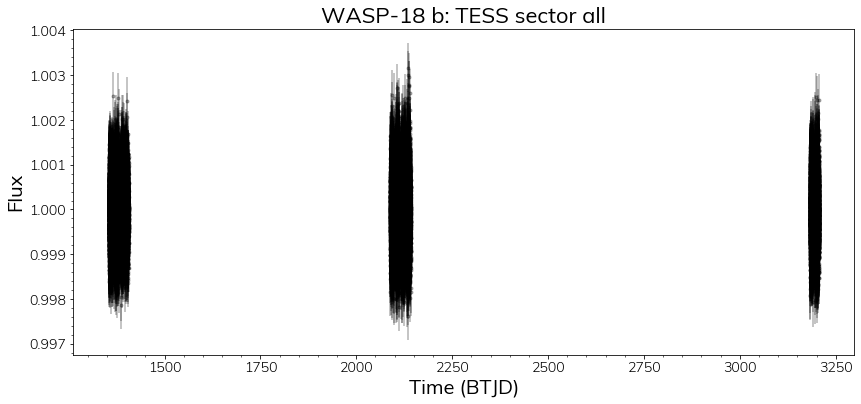

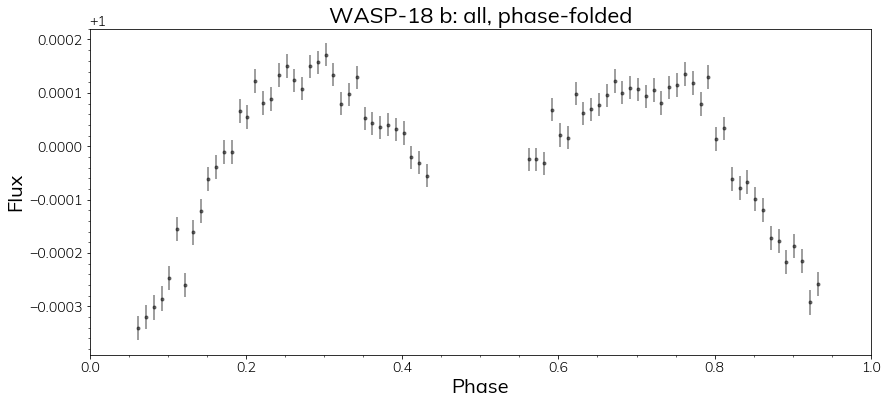

In [4]:
planet_name = 'WASP-18 b'
df = pd.read_csv('lightcurves/'+planet_name.replace(" ", "")+'.csv', comment='#', header=0)
sectors = np.unique(df.sector)
sector_ind = 'all' # set between 0 and len(sectors) to select an individual sector, set to 'all' for all sectors

if sector_ind == 'all':
    sector = 'all'
    time = np.array(df.time)
    flux = np.array(df.flux)
    flux_raw = np.array(df.flux_raw)
    flux_err = np.array(df.flux_err)
else:
    sector = sectors[sector_ind]
    sector_bool = df.sector == sector
    time = np.array(df.time)[sector_bool]
    flux = np.array(df.flux)[sector_bool]
    flux_raw = np.array(df.flux_raw)[sector_bool]
    flux_err = np.array(df.flux_err)[sector_bool]        

# Store data as a Lightkurve object to make it easier for phase-folding
lc_data = {'time': time,
           'flux': flux,
           'flux_err': flux_err
          }
lc_data = lk.LightCurve(lc_data)

NEA_result = NasaExoplanetArchive.query_object(planet_name)
TIC_id = NEA_result['tic_id'][0] # extracts the TESS Input Catalog ID number associated with the planet
ephemeris_ind = 1 
# Extract orbital period (P), mid-transit time (t_0), and transit duration (t_dur)
P, t_0, t_dur = NEA_result['pl_orbper'][ephemeris_ind], NEA_result['pl_tranmid'][ephemeris_ind], \
NEA_result['pl_trandur'][ephemeris_ind].value*u.hour
P_err = (abs(NEA_result['pl_orbpererr1'][ephemeris_ind]) + abs(NEA_result['pl_orbpererr2'][ephemeris_ind]))/2.
t_0_err = (abs(NEA_result['pl_tranmiderr1'][ephemeris_ind]) + abs(NEA_result['pl_tranmiderr1'][ephemeris_ind]))/2.
print('Period: ', P, '+/- ', P_err)
print('t_0: ', t_0, '+/- ', t_0_err)
print('Transit duration: ', t_dur)
t_0 = t_0 - 2457000.0*u.day

bin_width = 0.01 * u.day
lc_data_fold = TPC.fold_lk(lc_data, P, t_0)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
mask = lc_data_bin.flux_err > np.nanmean(lc_data_bin.flux_err) + 3*np.nanstd(lc_data_bin.flux_err)
lc_data_bin = lc_data_bin[~mask]

# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(time, flux, flux_err, fmt='.', color='k', alpha=0.3)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': TESS sector '+str(sector))
plt.show()

# Plot phase-folded lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0, 1)
plt.title(planet_name+': '+sector+', phase-folded')
plt.show()

# Model-fitting

Set up Bayesian framework

In [ ]:
# Names of all the model parameters
labels = [r'$t_0$', r'$P$', r'$f_p$', r'$\delta$',
          r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']
ndim = len(labels) # number of model parameters

# Define an array of booleans that describe whether the priors will be uniform (True) or Gaussian (False) in order
priors_bool = np.array([True]*ndim)
priors_bool[0:2] = np.array([False]*2) # Setting the first two parameters to have Gaussian priors

# Define pairs of values that describe the priors for each parameter in order
priors = np.array([[t_0.value, 5*t_0_err.value], # t_0, Gaussian prior from Exoplanet Archive
                   [P.value, 5*P_err.value], # P, Gaussian prior from Exoplanet Archive
                   [-2e-3, 2e-3], # f_p, uniform prior
                   [-np.pi, np.pi], # delta, uniform prior
                   [-1e-2, 1e-2], # B_1, uniform prior
                   [-1e-3, 1e-3], # A_2, uniform prior
                   [-1e-3, 1e-3], # B_2, uniform prior
                   [-1e-3, 1e-3], # A_3, uniform prior
                   [-1e-3, 1e-3]]) # B_3, uniform prior

Define model, likelihood function arguments, and prior transform function arguments

In [7]:
### Likelihood function ###
def psi_tot_noPulse_noA1(params, t):
    t_0, P, fp, delta, B1, A2, B2, A3, B3 = params
    return TPC.psi_tot_no_pulse(t, t_0, P, fp, delta, 0, B1, A2, B2, A3, B3)

def psi_tot_noA1(params, t):
    t_0, P, PI, alpha, beta, fp, delta, B1, A2, B2, A3, B3 = params
    return TPC.psi_tot(t, t_0, P, PI, alpha, beta, fp, delta, 0, B1, A2, B2, A3, B3)

loglike_args = (lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value,
                psi_tot_noPulse_noA1) # loglike function arguments
ptform_args = (priors, priors_bool) # prior_transform function arguments

Perform nested sampling

In [ ]:
# Initialize the sampler that will search the parameter space
sampler = DynamicNestedSampler(TPC.loglike, TPC.prior_transform, ndim,
                        logl_args=loglike_args, ptform_args=ptform_args)

# Run the sampler; we define convergence when the estimated contribution of the remaining prior volume to the
# total evidence falls below 1%
filename_root =''.join(planet_name.split())+'_sector'+str(sector)+'_v1' # filename at which to save progress
sampler.run_nested(dlogz_init=0.01, maxiter=100000, checkpoint_file=filename_root+'.save', print_progress=True)

# Save the results from running the sampler
res = sampler.results

# Extract the 50th percentile parameter samples as best fit parameters
params_best = np.array([dynesty.utils.quantile(res.samples[:, i], 0.50, 
                                              weights=res.importance_weights())[0] for i in range(ndim)])

9687it [1:03:37,  5.90s/it, batch: 0 | bound: 617 | nc: 2019 | ncall: 478556 | eff(%):  2.022 | loglstar:   -inf < 321077.775 <    inf | logz: 321054.373 +/-  0.211 | dlogz: 159.222 >  0.010]

Plot corner plot of posterior distribution

In [ ]:
# Restore sampler
# sampler = NestedSampler.restore(''.join(planet_name.split())+'_sector'+str(sector)+'_v1.save')

# Save the results from running the sampler
res = sampler.results

# Extract the 50th percentile parameter samples as best fit parameters
params_best = np.array([dynesty.utils.quantile(res.samples[:, i], 0.50, 
                                              weights=res.importance_weights())[0] for i in range(ndim)])

In [ ]:
### Corner plot ###

truths = (P.value, t_0.value, None, None, None, None, None, None, None, None)
labels = [r'$t_0$', r'$P$',  r'$\Pi$', r'$\alpha$', r'$\beta$', r'$f_p$', r'$\delta$',
          r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']

fig, axes = dyplot.cornerplot(res, show_titles=True, title_fmt='0.2e',
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(ndim, ndim, figsize=(30, 30)))

Plot best-fit model overlayed on data

In [ ]:
### Compute the model light curve ###
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[6]

# Calculate model and assign to a Lightkurve object
model = psi_tot_noA1(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Initialize figure
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 10))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value, fmt='.', color='k', alpha=0.5)
ax1.plot(lc_model.time.value, lc_model.flux.value, color='r', linewidth=3, label='TOI-1518 b best-fit')
ax1.set_ylabel('Normalized flux', fontsize=28)
ax1.set_xlim(2750, 2800)

# Plot residuals
residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
# residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
# ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
# ax2.axhline(0, color='k', zorder=0, linewidth=2)
# ax1.set_xlabel('Phase', fontsize=28)
# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)
# ax2.set_ylabel('Residuals')
# ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)
plt.show()

Example of model fitting

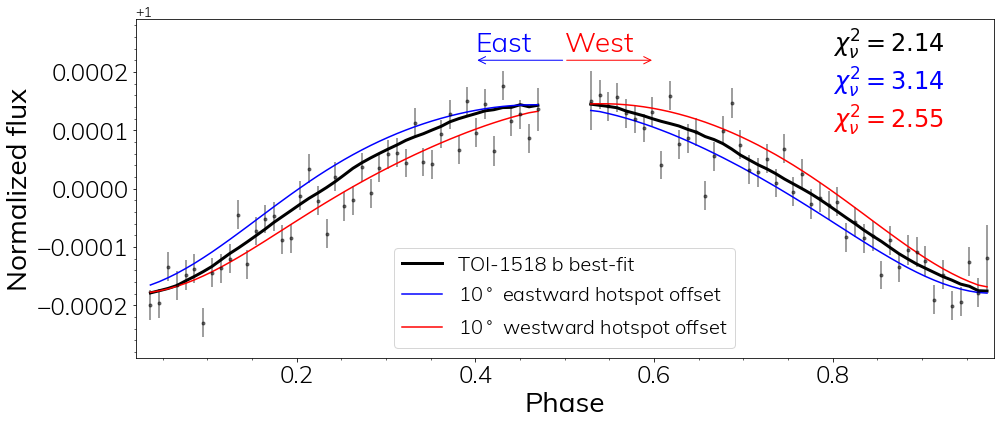

[ 1.78704927e+03  1.90260901e+00  1.22910302e+00  2.66298455e-05
  6.43091804e-06  1.23615437e-03 -7.99870435e-04 -1.58846842e-04
  1.18295167e-06 -1.86883806e-05 -5.08533487e-07 -3.71328072e-06]


In [67]:
### Compute the model light curve ###

# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[6]

# Calculate model and assign to a Lightkurve object
model = psi_tot_noA1(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)

params_east = np.hstack([params_best[0:2], params_best[5:]])
params_east[3] = 10 * np.pi/180
east = psi_tot_noPulse_noA1(params_east, lc_data.time.value)
lc_east = {'time': lc_data.time.value,
           'flux': east,
          }
lc_east = lk.LightCurve(lc_east)

params_west = np.hstack([params_best[0:2], params_best[5:]])
params_west[3] = -10 * np.pi/180
west = psi_tot_noPulse_noA1(params_west, lc_data.time.value)
lc_west = {'time': lc_data.time.value,
           'flux': west,
          }
lc_west = lk.LightCurve(lc_west)

# Phase fold and bin data and model
# bin_width = (9*u.min).to(u.day)/P_best * u.day
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_east_fold = TPC.fold_lk(lc_east, P_best, t_0_best)
lc_east_bin = lc_east_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_west_fold = TPC.fold_lk(lc_west, P_best, t_0_best)
lc_west_bin = lc_west_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

chisq_model = np.nansum(((lc_data_bin.flux - lc_model_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)
chisq_east = np.nansum(((lc_data_bin.flux - lc_east_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)
chisq_west = np.nansum(((lc_data_bin.flux - lc_west_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)

chisq_text_model = r'$\chi^2_\nu = '+str(round(chisq_model.value, 2))+'$'
chisq_text_east = r'$\chi^2_\nu = '+str(round(chisq_east.value, 2))+'$'
chisq_text_west = r'$\chi^2_\nu = '+str(round(chisq_west.value, 2))+'$'

# Initialize figure
fig, ax1 = plt.subplots(1, sharex=True, figsize=(14, 6))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
# ax1.scatter(lc_data_fold.time.value, lc_data_fold.flux.value, marker='.', color='k', alpha=0.05)
ax1.plot(lc_model_bin.time.value, lc_model_bin.flux.value, color='k', linewidth=3, label='TOI-1518 b best-fit')
ax1.plot(lc_east_bin.time.value, lc_east_bin.flux.value, color='blue', label=r'10$^\circ$ eastward hotspot offset')
ax1.plot(lc_west_bin.time.value, lc_west_bin.flux.value, color='red', label=r'10$^\circ$ westward hotspot offset')
ax1.set_ylabel('Normalized flux', fontsize=28)
ax1.set_xlim(0.02, 0.98)
ax1.set_ylim(1-0.00029, 1+0.00029)


ax1.annotate('', xy=(0.5, 1.00022), xytext=(0.4, 1.00022),
            fontsize=18, color='blue', arrowprops=dict(arrowstyle="<-", color='blue'))
ax1.annotate('', xy=(0.5, 1.00022), xytext=(0.6, 1.00022),
            fontsize=18, color='red', arrowprops=dict(arrowstyle="<-", color='red'))
ax1.text(0.4, 1.000235, 'East', color='blue', fontsize=28)
ax1.text(0.5, 1.000235, 'West', color='red', fontsize=28)

ax1.text(0.8, 1.000235, chisq_text_model, color='k', fontsize=24)
ax1.text(0.8, 1.00017, chisq_text_east, color='blue', fontsize=24)
ax1.text(0.8, 1.000105, chisq_text_west, color='red', fontsize=24)
# ax1.text(0.5-10./360, 1.0003, 'East', fontsize=18)


# # Plot residuals
# residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
# residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
# ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
# # ax2.scatter(lc_data_fold.time.value, residuals_fold, marker='.', color='k', alpha=0.05)
# ax2.axhline(0, color='k', zorder=0, linewidth=2)
ax1.set_xlabel('Phase', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# ax2.set_ylabel('Residuals')
# ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)
plt.savefig('../TOI-1518b.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print(params_best)